# Решение одномерной задачи Стефана
## Метод 1: эквивалентная теплоёмкость
Во всей расчётной области решается единое уравнение переноса тепла за счёт учёта скрытой теплоты фазового перехода в коэффициенте эффективной теплоёмкости:
$$
    \left(c(T^*) + L\delta(T^*-T^*_m)\right)\frac{\partial T^*}{\partial t} = \frac{\partial}{\partial x} \left(\frac{k(T^*)}{\rho} \frac{\partial T^*}{\partial x}\right).
$$

Обезразмеривание:
$$
    x' = \frac{x}{H}, \quad t' = \frac{\alpha_l t}{H^2}, \quad T' = \frac{T^*}{\delta T}.
$$

Уравнение в обезразмеренных величинах:
$$
    \left(c'(T) + \text{Ste}\delta(T-T_m)\right)\frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left(k'(T) \frac{\partial T}{\partial x}\right).
$$

Проверять численное решение будем на аналитическом решении одномерной двухфазной задачи Стефана.

Область - полубесконечная плоскость $x \in [0, \infty)$ в начальный момент заполненная водой при $T > T_m$. Граница $x = 0$ поддерживается при температуре $T < T_m$ в результате чего начинает образовываться лёд.

В численных расчётах область задаётся конечной, но достаточно большой, чтобы на решении не сказывалось влияние границы.

Граничные условия:
$T(x,t)|_{x=0} = T_{ice} < T_m, \quad T(x,t)|_{x=\infty} = T_{water} > T_m$

Начальное условие:
$T(x, t)|_{t=0} = T_{water}$.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import erf, erfc

In [14]:
T_m = 273.15   # Температура плавления, K
c_l = 4120.7   # Удельная теплоёмкость воды, J/(kg·K)
c_s = 2056.8   # Удельная теплоёмкость льда, J/(kg·K)
L = 3.33e5     # Удельная теплота плавления, J/kg
rho = 999.84   # Плотность, kg/m³
k_l = 0.59     # Теплопроводность воды, W/(m·K)
k_s = 2.21     # Теплопроводность льда, W/(m·K)

# Коэффициенты температуропроводности
alpha_l = k_l / (rho * c_l)
alpha_s = k_s / (rho * c_s)

# Температуры
T_i = 273.05   # Начальная температура льда
T_w = 278.15   # Начальная температура воды

H = 1.0
x0 = 0.5
n_x = 1001
dx = H / (n_x - 1)

t_end = 60 * 60 * 3
n_t = 60 * 60 * 3
dt = t_end / n_t

### Аналитическое решение

Найденное gamma: 0.000013
Положение фронта s(t=10800s) = 0.502780 м
-5.415189577129922


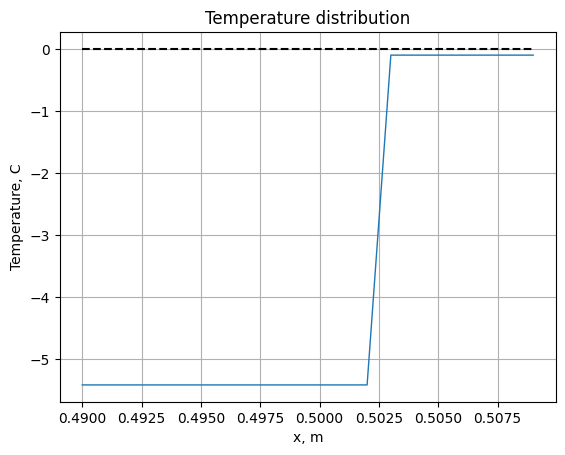

In [22]:
# Корни из коэффициентов температуропроводности
a_l = np.sqrt(alpha_l)
a_s = np.sqrt(alpha_s)

def stefan_equation(gamma):
    A_s = (T_m - T_i * erf(gamma / a_s)) / (1.0 - erf(gamma / a_s))
    B_s = T_i - A_s

    A_l = (T_m - T_w * erf(gamma / a_l)) / (1.0 - erf(gamma / a_l))
    B_l = -T_w + A_l
    
    flux_solid = k_s * B_s * np.exp(-gamma**2 / alpha_s) / np.sqrt(np.pi * alpha_s)
    flux_liquid = k_l * B_l * np.exp(-gamma**2 / alpha_l) / np.sqrt(np.pi * alpha_l)
    stefan_term = rho * L * gamma
    return flux_solid - flux_liquid - stefan_term
    
gamma0 = 0.001
gamma = fsolve(stefan_equation, gamma0)[0]
print(f"Найденное gamma: {gamma:.6f}")

# Положение фронта плавления
s = x0 + 2.0 * gamma * np.sqrt(t_end)
print(f"Положение фронта s(t={t_end}s) = {s:.6f} м")

T_analytical = np.zeros(n_x)
x = np.linspace(0, H, n_x)

for i in range(n_x):
    if x[i] < s:
        A_l = (T_m - T_w * erf(gamma / a_l)) / (1.0 - erf(gamma / a_l))
        B_l = -T_w + A_l
        T_analytical[i] = A_l + B_l * erf((x[i] - x0) / np.sqrt(4.0 * alpha_l * t_end))
    else:
        A_s = (T_m - T_i * erf(gamma / a_s)) / (1.0 - erf(gamma / a_s))
        B_s = T_i - A_s
        T_analytical[i] = A_s + B_s * erf((x[i] - x0) / np.sqrt(4.0 * alpha_s * t_end))

print(np.min(T_analytical-273.15))

# Визуализация
c = int(n_x//2)
ax = plt.axes()
plt.plot(x[c-10:c+10], T_analytical[c-10:c+10] - 273.15, linewidth=1)
plt.plot(x[c-10:c+10], np.zeros(n_x)[c-10:c+10], color="black", linestyle='dashed')
plt.grid()
ax.set_title("Temperature distribution")
ax.set_xlabel("x, m")
ax.set_ylabel("Temperature, C")
plt.show()

### Дискретизация уравнения

$$
    \frac{c^{n+1}_i T^{n+1}_i - c^{n}_i T^{n}_i}{\tau} - k^{n+1}_{i+1/2}\frac{T^{n+1}_{i+1} - T^{n+1}_i}{h} + k^{n+1}_{i-1/2}\frac{T^{n+1}_i - T^{n+1}_{i-1}}{h} + \frac{1}{Ste}\frac{f^{n+1}_i - f^{n}_i}{\tau} = 0
$$

$$
    - \tau \frac{k^{n+1}_{i-1/2}}{h} T^{n+1}_{i-1} + \left( c^{n+1}_i + \tau \frac{k^{n+1}_{i-1/2} + k^{n+1}_{i+1/2}}{h} \right) T^{n+1}_i - \tau \frac{k^{n+1}_{i+1/2}}{h} T^{n+1}_{i+1} = c^{n}_i T^{n}_i - \frac{1}{\mathrm{Ste}} \left( f^{n+1}_i - f^{n}_i \right)
$$

In [4]:
delta = 0.1 / delta_T # половина зоны двухфазного состояния обезразмеренная на delta_T
h = dx / H # обезразмеренный шаг по пространству
tau = dt * alpha_l / H**2 # обезразмеренный шаг по времени

def calculate_liquid_fraction(T: np.ndarray):
    return 0.5 * (1.0 + np.tanh(T / delta))

def calculate_c_eff(T: np.ndarray, liquid_frac: np.ndarray):
    c = c_s + liquid_frac * (c_l - c_s)
    return c / c_l

def calculate_k_eff(T: np.ndarray, liquid_frac: np.ndarray):
    k = k_s + liquid_frac * (k_l - k_s)
    return k / k_l

NameError: name 'delta_T' is not defined

In [ ]:
T_old = np.copy(T_init_nd)
T_k = np.copy(T_init_nd)
for n in range(1, n_t + 1):
    t = n * tau